In [23]:
#!pip install pandas

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Lectura de archivo

In [25]:
df = pd.read_csv('dataset.csv')
df

,modelo,año_registro,km_recorridos,kilometraje(kmpl),caballos_fuerza,precio_dolares(miles)
0,2017 Mercedes-Benz S-Class S400,jul-17,56000,7.81,394,63.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,30615,17.40,118,8.99
2,2018 BMW X1 sDrive 20d xLine,Sep-18,24000,20.68,144,23.75
3,2019 Kia Seltos GTX Plus,Dec-19,18378,16.50,367,13.56
4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,44900,14.67,141,24.00
...,...,...,...,...,...,...
495,2016 BMW X1 sDrive 20d xLine,jul-16,70000,20.68,302,15.50
496,2019 Kia Seltos GTX Plus DCT,nov-19,85540,16.50,287,13.86
497,2023 Mahindra XUV300 W6 Turbo,2023,10000,11.97,356,11.70
498,2019 Maruti Baleno Alpha,mar-19,50170,21.01,157,6.87


### Analisis de Archivo

In [26]:
df.describe()

,km_recorridos,kilometraje(kmpl),caballos_fuerza,precio_dolares(miles)
count,500.000000,500.000000,500.000000,500.00000
mean,48145.280000,17.567660,246.396000,297.26080
std,26916.506686,8.453698,86.890247,4421.69376
min,620.000000,7.810000,100.000000,1.09000
25%,30000.000000,14.285000,172.750000,5.42250
50%,46926.500000,17.800000,246.000000,9.27500
75%,64000.000000,19.950000,320.000000,22.50000
max,154000.000000,147.510000,400.000000,70000.00000


### Extraccion y transformacion de informacion

In [27]:
modelo = df['modelo'].to_numpy()
km_recorridos = df['km_recorridos'].to_numpy()
kilometraje = df['kilometraje(kmpl)'].to_numpy()
caballos_fuerza = df['caballos_fuerza'].to_numpy()
df['precio_dolares(miles)'] = np.where(df['precio_dolares(miles)'] > 100, df['precio_dolares(miles)'] / 1000, df['precio_dolares(miles)'])
precio_dolares = df['precio_dolares(miles)'].to_numpy()


In [28]:
anho_registro_raw = df['año_registro']
anho_registro = np.array([])

#Pasa por cada valor de la columna
for item in anho_registro_raw:
    try: #Intenta convertirlo del formato mes-año abreviados a datetime (%b significa mes abreviado)
        anho_registro = np.append(anho_registro,pd.to_datetime(item.lower(), format='%b-%y'))

    except: #Si falla, intenta el otro formato que consiste el año completo
        anho_registro = np.append(anho_registro,pd.to_datetime(item.lower(), format='%Y'))


# Tomamos el año menor de todas las fechas como referencia 
min_anho = anho_registro.min().year  

anho_registro_transformado = np.array([fecha.year - min_anho for fecha in anho_registro])

# Cambiamos el año de registro por un dato utilizable siendo un numero entero
df['año_registro'] = anho_registro_transformado


### Entrenamiento del modelo y lógica

### Precio en general

#### Regresion Lineal Simple

In [29]:
# Se seleccionan solo las variables númericas de los datos
df_numeric = df.select_dtypes(include=[np.number])

# Se calcula la correlación para ver como interactuan las variables entre si
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

                       año_registro  km_recorridos  kilometraje(kmpl)  \
año_registro               1.000000      -0.665439           0.071042   
km_recorridos             -0.665439       1.000000          -0.073970   
kilometraje(kmpl)          0.071042      -0.073970           1.000000   
caballos_fuerza           -0.001278       0.034789           0.002662   
precio_dolares(miles)      0.319838      -0.226827          -0.099290   

                       caballos_fuerza  precio_dolares(miles)  
año_registro                 -0.001278               0.319838  
km_recorridos                 0.034789              -0.226827  
kilometraje(kmpl)             0.002662              -0.099290  
caballos_fuerza               1.000000              -0.017857  
precio_dolares(miles)        -0.017857               1.000000  


Podemos observar una relacion directamente **fuerte** entre el precio y el año de registro, por lo que se puede observar que el año tiene una influencia en el precio.

In [30]:


# Creamos nuestro dataset de características (X) y la variable objetivo (y)
X = df_numeric[['año_registro']]
y = df_numeric['precio_dolares(miles)']

# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

modelo_regresion = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento
modelo_regresion.fit(X_train, y_train)

LinearRegression()

In [31]:

y_pred = modelo_regresion.predict(X_test)

# Resultados de Regresion Lineal
print(f"Error Absoluto Medio de testeo: {mean_absolute_error(y_test, y_pred)}")
print(f"Metrica R^2 de testeo: {r2_score(y_test, y_pred)}")

regresion_simple = modelo_regresion


Error Absoluto Medio de testeo: 12.264582624495787
Metrica R^2 de testeo: 0.14290574882632046


Podemos observar que el valor del precio se desvia por 12 miles de dolares.

En la metrica R^2 tenemos que solo tiene un 14.29 % de variabilidad.

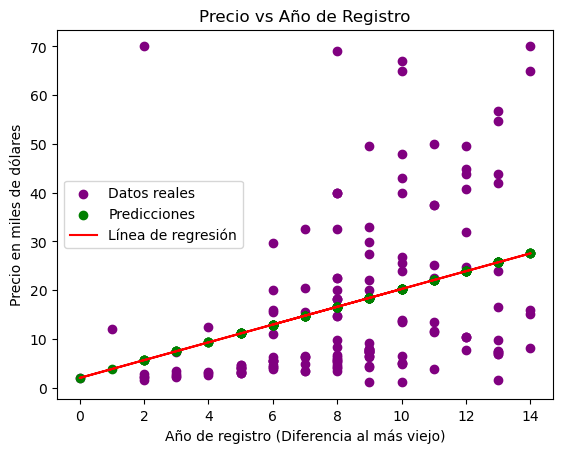

Coeficiente: [1.82538461]
Intercepto: 2.003756066514182


In [32]:
plt.scatter(X_test, y_test, color='purple', label='Datos reales')       
plt.scatter(X_test, y_pred, color='green', label='Predicciones')      
plt.plot(X_test, y_pred, color='red', label='Línea de regresión')  

plt.xlabel('Año de registro (Diferencia al más viejo)')
plt.ylabel('Precio en miles de dólares')
plt.title('Precio vs Año de Registro')
plt.legend()
plt.show()

# Imprimir los coeficientes de la regresión
print('Coeficiente:', modelo_regresion.coef_)
print('Intercepto:', modelo_regresion.intercept_)

#### Regresion Multiple

In [33]:



# Creamos nuestro dataset de características (X) y la variable objetivo (y)
X = df_numeric[['año_registro', 'km_recorridos', 'kilometraje(kmpl)', 'caballos_fuerza']]
y = df_numeric['precio_dolares(miles)']

# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

modelo_regresion = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento
modelo_regresion.fit(X_train, y_train)

LinearRegression()

In [34]:

y_pred = modelo_regresion.predict(X_test)

# Resultados de Regresion Lineal
print(f"Error Absoluto Medio de testeo: {mean_absolute_error(y_test, y_pred)}")
print(f"Metrica R^2 de testeo: {r2_score(y_test, y_pred)}")

regresion_multiple = modelo_regresion

Error Absoluto Medio de testeo: 12.614141848072572
Metrica R^2 de testeo: 0.14501026257918792


#### Regresión Polinomial
##### Año / Precio

In [35]:


poly_features = PolynomialFeatures(degree=3)

X = df[['año_registro']]
X_poly = poly_features.fit_transform(X)

y = df['precio_dolares(miles)']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=46)

modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train, y_train)

y_pred = modelo_regresion.predict(X_test)

print(f"Error Absoluto Medio de testeo: {mean_absolute_error(y_test, y_pred)}")
print(f"Metrica R^2 de testeo: {r2_score(y_test, y_pred)}")

polinomial_anho_precio = modelo_regresion

Error Absoluto Medio de testeo: 10.013504940985499
Metrica R^2 de testeo: 0.19029034913005316


Podemos observar que el valor del precio se desvia por 10.01 miles de dolares, lo cual es un porcentaje aceptable.

En la metrica R^2 tenemos que solo tiene un 19.02 % de variabilidad.

##### km_recorridos / Precio

In [36]:


poly_features = PolynomialFeatures(degree=3)

X = df[['km_recorridos']]
X_poly = poly_features.fit_transform(X)

y = df['precio_dolares(miles)']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state= 8)

modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train, y_train)

y_pred = modelo_regresion.predict(X_test)

print(f"Error Absoluto Medio de testeo: {mean_absolute_error(y_test, y_pred)}")
print(f"Metrica R^2 de testeo: {r2_score(y_test, y_pred)}")

polinomial_km_precio = modelo_regresion

Error Absoluto Medio de testeo: 11.054103830153986
Metrica R^2 de testeo: 0.132593167767591


##### Kilometraje / Precio

In [37]:


poly_features = PolynomialFeatures(degree=3)

X = df[['kilometraje(kmpl)']]
X_poly = poly_features.fit_transform(X)

y = df['precio_dolares(miles)']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state= 7)

modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train, y_train)

y_pred = modelo_regresion.predict(X_test)

print(f"Error Absoluto Medio de testeo: {mean_absolute_error(y_test, y_pred)}")
print(f"Metrica R^2 de testeo: {r2_score(y_test, y_pred)}")

polinomial_kmpl_precio = modelo_regresion

Error Absoluto Medio de testeo: 12.277822831269196
Metrica R^2 de testeo: 0.16225533895709499


##### Caballos fuerza / Precio

In [38]:


poly_features = PolynomialFeatures(degree=3)

X = df[['caballos_fuerza']]
X_poly = poly_features.fit_transform(X)

y = df['precio_dolares(miles)']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state= 6)

modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train, y_train)

y_pred = modelo_regresion.predict(X_test)

print(f"Error Absoluto Medio de testeo: {mean_absolute_error(y_test, y_pred)}")
print(f"Metrica R^2 de testeo: {r2_score(y_test, y_pred)}")

polinomial_fuerza_precio = modelo_regresion

Error Absoluto Medio de testeo: 12.778344740214038
Metrica R^2 de testeo: 0.004660945188021959


Para predecir el precio tomando en cuenta todas las variables que afectan el precio, este modelo es el más adecuado tomando en cuenta que el precio NO sigue una linea recta y es una tendencia más compleja que una relacion lineal entre variables.

### Representación Gráfica

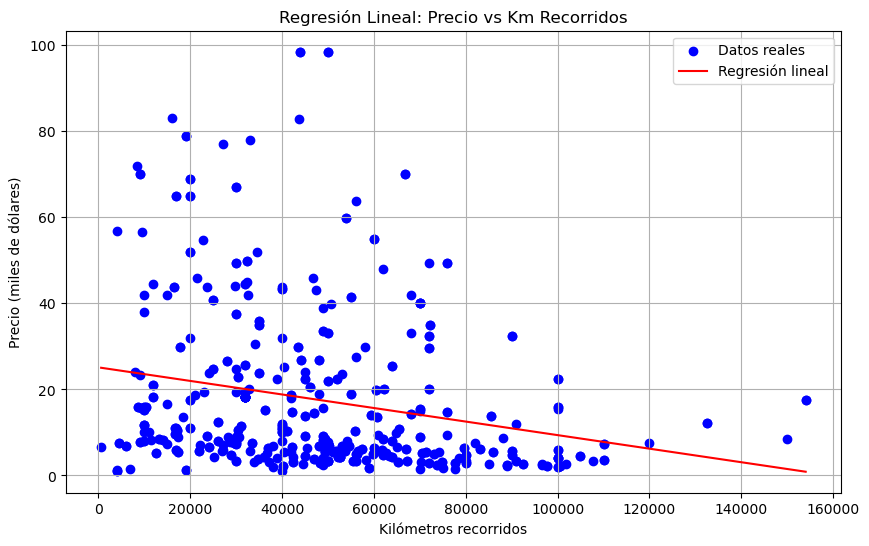

In [39]:
X = df[["km_recorridos"]].values
y = df["precio_dolares(miles)"].values

modelo = LinearRegression()
modelo.fit(X, y)

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = modelo.predict(x_range)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label="Datos reales")
plt.plot(x_range, y_pred, color='red', label="Regresión lineal")
plt.xlabel("Kilómetros recorridos")
plt.ylabel("Precio (miles de dólares)")
plt.title("Regresión Lineal: Precio vs Km Recorridos")
plt.legend()
plt.grid(True)
plt.show()


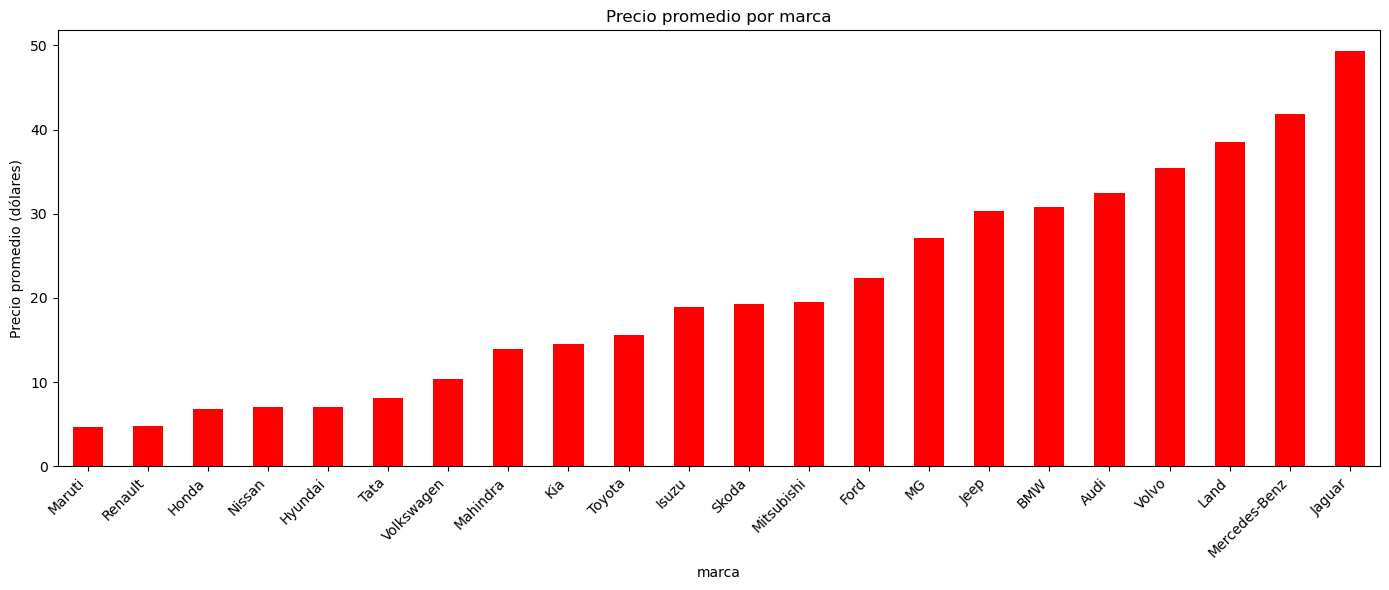

In [40]:

df['marca'] = df['modelo'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else "Desconocido")

precio_marca = df.groupby('marca')["precio_dolares(miles)"].mean().sort_values()

plt.figure(figsize=(14, 6))
precio_marca.plot(kind='bar', color='red')
plt.title("Precio promedio por marca")
plt.ylabel("Precio promedio (dólares)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


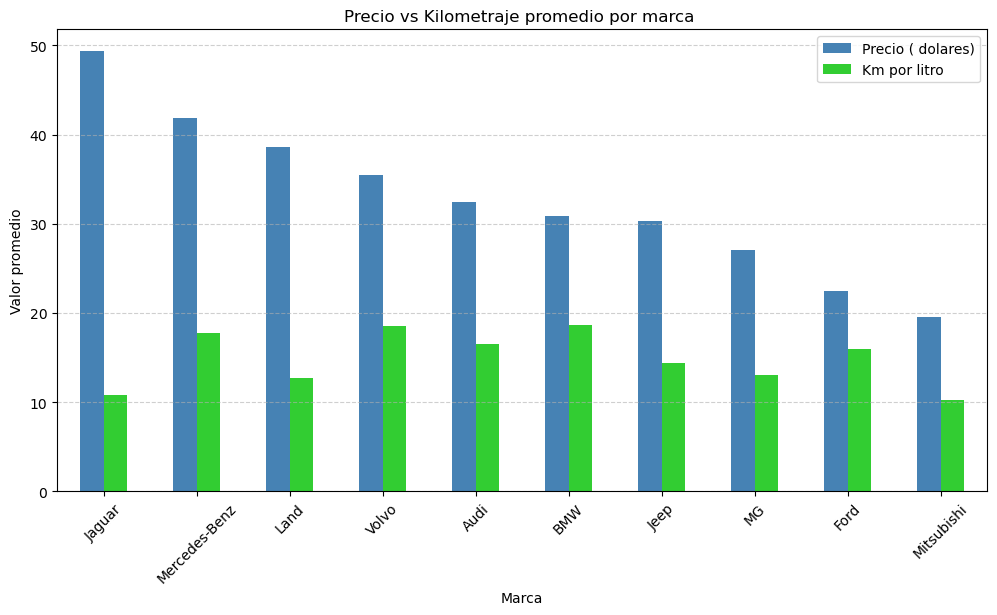

In [41]:
marca_rendimiento = df.groupby('marca').agg(
    precio_promedio=('precio_dolares(miles)', 'mean'),
    kilometraje_promedio=('kilometraje(kmpl)', 'mean')
).dropna().sort_values(by='precio_promedio', ascending=False).head(10)


marca_rendimiento.plot(
    kind='bar',
    figsize=(12, 6),
    color=['steelblue', 'limegreen']
)

plt.title("Precio vs Kilometraje promedio por marca ")
plt.xlabel("Marca")
plt.ylabel("Valor promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(["Precio ( dolares)", "Km por litro"])
plt.show()


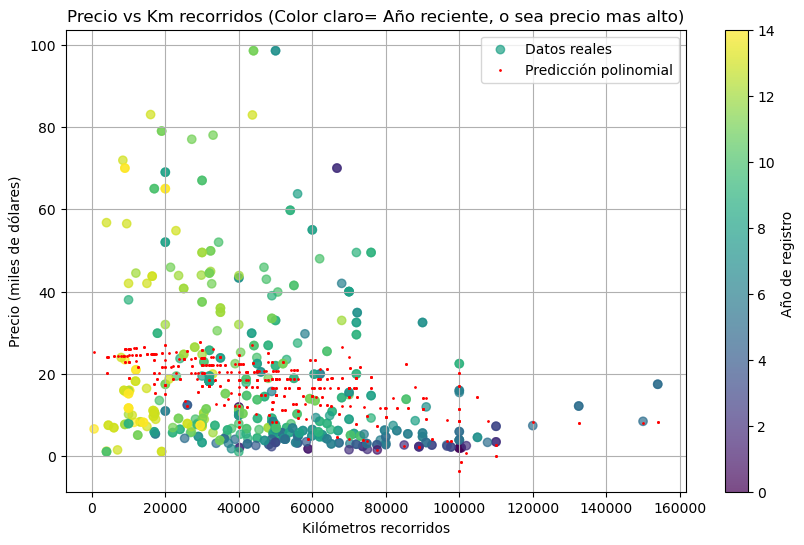

In [42]:
X = df[["km_recorridos"]].copy()
X["año_registro"] = df["año_registro"].astype(float)
y = df["precio_dolares(miles)"].values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

modelo_poly2d = LinearRegression()
modelo_poly2d.fit(X_poly, y)

y_pred = modelo_poly2d.predict(X_poly)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["km_recorridos"], y, c=df["año_registro"], cmap="viridis", alpha=0.7, label="Datos reales")
plt.plot(df["km_recorridos"], y_pred, 'r.', markersize=2, label="Predicción polinomial")
plt.title("Precio vs Km recorridos (Color claro= Año reciente, o sea precio mas alto)")
plt.xlabel("Kilómetros recorridos")
plt.ylabel("Precio (miles de dólares)")
plt.colorbar(scatter, label="Año de registro ")
plt.legend()
plt.grid(True)
plt.show()


#profe para entende resta grafica se interpreta como
#los colores más oscuros (morado/azul) representan autos más antiguos.
#Los colores más claros (verde-limón/amarillo) representan autos más nuevos.

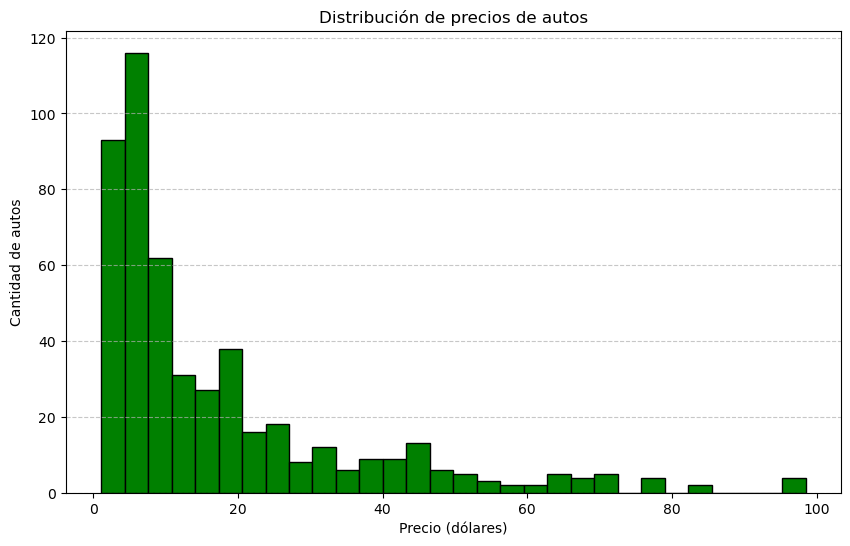

In [43]:

#ver como se distribuyen los precios de los autos

plt.figure(figsize=(10, 6))
plt.hist(df['precio_dolares(miles)'], bins=30, color='green',edgecolor='black')
plt.title('Distribución de precios de autos')
plt.xlabel('Precio (dólares)')
plt.ylabel('Cantidad de autos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Evaluación

In [44]:
def predecir_precio():
    try:
        km = float(input("Ingresa los kilómetros recorridos del auto: "))
        prediccion = modelo.predict([[km]])
        print(f"precio estimado del vehículo: ${prediccion[0]:.2f} mil dólares")
    except:
        print("ingresa un número válido para los kilómetros recorridos.")

predecir_precio()


ingresa un número válido para los kilómetros recorridos.


### CONCLUSIONES

- ¿Para qué sirven los modelos de regresión en procesos de predicción?
  - Para identificar relaciones entre las variables, permite estimar el valor de la variable dependiente (precio del vehiculo) en funcion de las caracteristicas que son las variables independientes (año de registro, km o caballos de fuerza), basicamente sirven para analizar cómo diferentes características influyen en que el resultado sea diferente.
  
- ¿Por qué usaste el modelo que elegiste?
  - Se implemento la regresion polinomial para poder encontrar la relacion entre las variables independientes y el precio del vehiculo, como no es un modelo donde el precio suba de forma lineal conforme una variable y más bien depende de varios factores, la regresión polinomial fue la mejor para modelar las relaciones complejas y poder hacer predicciones un poco más precisas.
  
- ¿Cuál de las variables independientes consideras que influye más en el precio del
vehículo y por qué?
    - Vimos una relacion un tanto directa entre los km recorridos y el precio. Entre menos kilometros recorridos, tendia a costar mas. Tambien vimos una clara relacion entre cuantos años tiene contra el auto mas antiguo. Entre mas años de diferencia haya, es decir, mas nuevo el coche, mayor costo.

- ¿Qué sesgos crees que puedan existir en este tipo de modelos?
    - Si los datos son muy dispersos, el modelo llega a ser poco util. Tambien si hay valores "outliers", el modelo se ve altamente modificado por solo un dato o dos.
    
- ¿Para qué crees que pueda ser útil un modelo de regresión en aplicaciones o caso de uso RELACIONADOS a tu carrera?
    - Se puede usar para estimar rendimiento comparado con componentes de una computadora, tambien para calcular el trafico en una pagina web o un servicio dependiendo de la cantidad de usuarios posible.



# Bibliografia de uso de skLearn
-   Scikit-Learn. (2025, abril 8). Mastering multiple linear regression in Scikit-Learn: A step-by-step guide [Video]. YouTube. https://www.youtube.com/watch?v=R2Zb5s_RrDU